In [123]:
# !pip install torch
# !pip install torchvision

#### Imports

- `torch`, `torch.nn`, `torch.optim`: For building and training the model.
- `datasets`, `transforms`: To load and preprocess data.
- `tqdm`: For progress bars.
- `numpy`, `matplotlib.pyplot`: For numerical operations and plotting.
- `make_grid`: To visualize images.

#### Device Setup

Sets the computation device to GPU if available, otherwise defaults to CPU.

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### FCVAE Class

A fully connected Variational Autoencoder (VAE) with the following components:

- **Encoder**:
  - Three fully connected layers (`fc1`, `fc2`, `fc3`) that transform the input to a latent space.
  - Two additional layers (`fc_mu`, `fc_logvar`) for computing the mean (`mu`) and log-variance (`logvar`) of the latent variable.

- **Latent to Hidden**:
  - A fully connected layer (`z_fc`) that maps the latent vector to a hidden space.

- **Decoder**:
  - Three fully connected layers (`fc4`, `fc5`, `fc6`) that reconstruct the input from the latent variable.

- **Methods**:
  - `encode(x)`: Encodes the input `x` into `mu` and `logvar`.
  - `reparameterize(mu, logvar)`: Applies the reparameterization trick to sample from the latent space.
  - `decode(z)`: Decodes the latent variable `z` back into the input space.
  - `forward(x)`: The full forward pass, combining encoding, reparameterization, and decoding.

In [125]:
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)

        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = nn.functional.leaky_relu(self.fc1(x), negative_slope=0.2)
        h2 = nn.functional.leaky_relu(self.fc2(h1), negative_slope=0.2)
        h3 = nn.functional.leaky_relu(self.fc3(h2), negative_slope=0.2)
        mu = self.fc_mu(h3)
        logvar = self.fc_logvar(h3)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = nn.functional.leaky_relu(self.z_fc(z), negative_slope=0.2)
        h = nn.functional.leaky_relu(self.fc4(h), negative_slope=0.2)
        h = nn.functional.leaky_relu(self.fc5(h), negative_slope=0.2)
        x_recon = torch.tanh(self.fc6(h))  
        return x_recon.view(-1, 3072)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

#### ConvVAE Class

A convolutional Variational Autoencoder (VAE) with the following components:

- **Encoder**:
  - Four convolutional layers (`conv1`, `conv2`, `conv3`, `conv4`) followed by batch normalization to extract features.
  - Two fully connected layers (`conv_mu`, `conv_logvar`) for generating the mean (`mu`) and log-variance (`logvar`) of the latent variable.

- **Latent Space**:
  - A fully connected layer (`z`) that maps the latent vector to the shape of the encoded features.

- **Decoder**:
  - Four transposed convolutional layers (`deconv1`, `deconv2`, `deconv3`, `deconv4`) followed by batch normalization to reconstruct the image from the latent vector.

- **Activation Functions**:
  - Leaky ReLU for the encoder and decoder layers.
  - Tanh activation in the final layer of the decoder for image output.

- **Methods**:
  - `encode(x)`: Encodes the input `x` into `mu` and `logvar`.
  - `reparameterize(mu, logvar)`: Samples from the latent space using the reparameterization trick.
  - `decode(z)`: Decodes the latent variable `z` back into the image space.
  - `forward(x)`: The full forward pass, combining encoding, reparameterization, and decoding.

In [118]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
               
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


#### Loss Function

- **MSE**: Measures reconstruction error.
- **KLD**: Regularizes the latent space.

#### Training

- Optimizes the VAE using MSE and KLD loss over multiple epochs.
- Progress is tracked with `tqdm`.

In [119]:
# Loss function
def loss_function(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

In [120]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'fcvae':
                recon_batch = recon_batch.view(-1, 3072).to(device)
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [121]:
num_epochs = 15
lr = 1e-3

#### Training the CVAE

- **Data Transformation**: Normalizes CIFAR-10 data for the CVAE.
- **DataLoader**: Loads training data with a batch size of 64.
- **Model**: Initializes the `ConvVAE` with a latent dimension of 128.
- **Optimizer**: Uses Adam optimizer with a learning rate of `lr`.
- **Training Loop**: Trains the model for `num_epochs` and tracks progress with the `train` function.

In [102]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.FashionMNIST('./data2/cvae_fmnist', train=True, download=True, transform=transform_cvae) 
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Epoch 1: 100%|██████████| 938/938 [00:35<00:00, 26.41batch/s, kld_loss=38.3, recon_loss=195, train_loss=233]  


Epoch 1/15 train loss: 232.86793266601563 mse loss: 194.5527351155599 kld loss: 38.315197182210284


Epoch 2: 100%|██████████| 938/938 [00:35<00:00, 26.33batch/s, kld_loss=34.7, recon_loss=108, train_loss=143]    


Epoch 2/15 train loss: 142.53629029134115 mse loss: 107.83710715332032 kld loss: 34.699183215332035


Epoch 3: 100%|██████████| 938/938 [00:28<00:00, 32.92batch/s, kld_loss=34.4, recon_loss=94.4, train_loss=129]   


Epoch 3/15 train loss: 128.84406331380208 mse loss: 94.4438370361328 kld loss: 34.40022613728841


Epoch 4: 100%|██████████| 938/938 [00:28<00:00, 32.97batch/s, kld_loss=34.3, recon_loss=87.9, train_loss=122]  


Epoch 4/15 train loss: 122.17393998209636 mse loss: 87.89992923177083 kld loss: 34.27401070760091


Epoch 5: 100%|██████████| 938/938 [00:28<00:00, 33.15batch/s, kld_loss=34.3, recon_loss=84.1, train_loss=118]  


Epoch 5/15 train loss: 118.4041302734375 mse loss: 84.13170385742187 kld loss: 34.272426387532555


Epoch 6: 100%|██████████| 938/938 [00:28<00:00, 32.81batch/s, kld_loss=34.2, recon_loss=80.7, train_loss=115]  


Epoch 6/15 train loss: 114.94835707194011 mse loss: 80.74451499023438 kld loss: 34.2038419535319


Epoch 7: 100%|██████████| 938/938 [00:28<00:00, 32.81batch/s, kld_loss=34.2, recon_loss=78.8, train_loss=113]  


Epoch 7/15 train loss: 112.95160607096354 mse loss: 78.79533404134115 kld loss: 34.15627201131185


Epoch 8: 100%|██████████| 938/938 [00:28<00:00, 32.86batch/s, kld_loss=34.1, recon_loss=76.5, train_loss=111]  


Epoch 8/15 train loss: 110.591962109375 mse loss: 76.49415391438802 kld loss: 34.09780802408854


Epoch 9: 100%|██████████| 938/938 [00:28<00:00, 32.88batch/s, kld_loss=34.1, recon_loss=75.3, train_loss=109]  


Epoch 9/15 train loss: 109.31949763183594 mse loss: 75.2591049601237 kld loss: 34.0603926188151


Epoch 10: 100%|██████████| 938/938 [00:28<00:00, 32.84batch/s, kld_loss=34, recon_loss=73.9, train_loss=108]    


Epoch 10/15 train loss: 107.90222909342448 mse loss: 73.8772476155599 kld loss: 34.02498155517578


Epoch 11: 100%|██████████| 938/938 [00:28<00:00, 32.84batch/s, kld_loss=34, recon_loss=72.7, train_loss=107]    


Epoch 11/15 train loss: 106.76497965901693 mse loss: 72.74534249267577 kld loss: 34.01963707682292


Epoch 12: 100%|██████████| 938/938 [00:28<00:00, 32.86batch/s, kld_loss=34, recon_loss=71.5, train_loss=106]    


Epoch 12/15 train loss: 105.52152381998698 mse loss: 71.48464350992839 kld loss: 34.03688044637044


Epoch 13: 100%|██████████| 938/938 [00:28<00:00, 33.16batch/s, kld_loss=34, recon_loss=71, train_loss=105]      


Epoch 13/15 train loss: 105.00750775553385 mse loss: 70.97523085123697 kld loss: 34.032276951090495


Epoch 14: 100%|██████████| 938/938 [00:28<00:00, 33.10batch/s, kld_loss=34, recon_loss=70, train_loss=104]      


Epoch 14/15 train loss: 103.95902725423177 mse loss: 69.97391729329428 kld loss: 33.985109908040364


Epoch 15: 100%|██████████| 938/938 [00:28<00:00, 33.01batch/s, kld_loss=34, recon_loss=69.2, train_loss=103]    

Epoch 15/15 train loss: 103.19820047607422 mse loss: 69.18617823079427 kld loss: 34.01202237752279


#### Training the FCVAE

- **Data Transformation**: Converts CIFAR-10 data to tensor format.
- **DataLoader**: Loads training data with a batch size of 64.
- **Model**: Initializes the `FCVAE` with input dimension 3072, hidden dimension 1000, and latent dimension 128.
- **Optimizer**: Uses Adam optimizer with a learning rate of `lr`.
- **Training Loop**: Trains the model for `num_epochs` using the `train` function.

In [126]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_fcvae = datasets.FashionMNIST('./data2/fcvae_fmnist', train=True, download=True, transform=transform_fcvae) 
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128).to(device)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Epoch 1: 100%|██████████| 938/938 [00:22<00:00, 41.81batch/s, kld_loss=32.9, recon_loss=228, train_loss=261]  


Epoch 1/15 train loss: 260.7434581624349 mse loss: 227.8619897623698 kld loss: 32.88146865539551


Epoch 2: 100%|██████████| 938/938 [00:22<00:00, 42.60batch/s, kld_loss=30.4, recon_loss=149, train_loss=179]   


Epoch 2/15 train loss: 179.2476650065104 mse loss: 148.86844627278646 kld loss: 30.37921883544922


Epoch 3: 100%|██████████| 938/938 [00:22<00:00, 41.90batch/s, kld_loss=30.2, recon_loss=134, train_loss=164]   


Epoch 3/15 train loss: 164.474354305013 mse loss: 134.27092024739582 kld loss: 30.20343405456543


Epoch 4: 100%|██████████| 938/938 [00:23<00:00, 40.74batch/s, kld_loss=29.9, recon_loss=126, train_loss=156]    


Epoch 4/15 train loss: 156.2422206624349 mse loss: 126.35419606119791 kld loss: 29.888024252319337


Epoch 5: 100%|██████████| 938/938 [00:22<00:00, 41.24batch/s, kld_loss=29.9, recon_loss=120, train_loss=150]  


Epoch 5/15 train loss: 150.13373311360678 mse loss: 120.21595057779948 kld loss: 29.917782802327473


Epoch 6: 100%|██████████| 938/938 [00:22<00:00, 41.28batch/s, kld_loss=30, recon_loss=116, train_loss=146]      


Epoch 6/15 train loss: 145.64806108398437 mse loss: 115.69062202555338 kld loss: 29.957439137776692


Epoch 7: 100%|██████████| 938/938 [00:22<00:00, 42.40batch/s, kld_loss=30, recon_loss=112, train_loss=142]      


Epoch 7/15 train loss: 142.24886241861978 mse loss: 112.27149549967447 kld loss: 29.977366950480143


Epoch 8: 100%|██████████| 938/938 [00:22<00:00, 40.86batch/s, kld_loss=30.1, recon_loss=110, train_loss=140]    


Epoch 8/15 train loss: 140.00795115559896 mse loss: 109.94385768636067 kld loss: 30.06409341023763


Epoch 9: 100%|██████████| 938/938 [00:22<00:00, 42.04batch/s, kld_loss=30.2, recon_loss=108, train_loss=139]    


Epoch 9/15 train loss: 138.5518738606771 mse loss: 108.37970693359375 kld loss: 30.17216715596517


Epoch 10: 100%|██████████| 938/938 [00:39<00:00, 23.53batch/s, kld_loss=30.4, recon_loss=107, train_loss=138]   


Epoch 10/15 train loss: 137.56626422932942 mse loss: 107.20653113606771 kld loss: 30.35973335469564


Epoch 11: 100%|██████████| 938/938 [00:23<00:00, 40.47batch/s, kld_loss=30.1, recon_loss=105, train_loss=135]   


Epoch 11/15 train loss: 134.5993667154948 mse loss: 104.53744252522786 kld loss: 30.06192383931478


Epoch 12: 100%|██████████| 938/938 [00:25<00:00, 37.11batch/s, kld_loss=30.3, recon_loss=104, train_loss=135]    


Epoch 12/15 train loss: 134.74183520507813 mse loss: 104.4048627685547 kld loss: 30.336972676595053


Epoch 13: 100%|██████████| 938/938 [00:23<00:00, 39.35batch/s, kld_loss=30.3, recon_loss=103, train_loss=134]   


Epoch 13/15 train loss: 133.51940810953775 mse loss: 103.20767808430989 kld loss: 30.31173012084961


Epoch 14: 100%|██████████| 938/938 [00:28<00:00, 33.01batch/s, kld_loss=30.3, recon_loss=102, train_loss=132]    


Epoch 14/15 train loss: 132.47111160074869 mse loss: 102.20574927978515 kld loss: 30.26536216430664


Epoch 15: 100%|██████████| 938/938 [00:30<00:00, 30.93batch/s, kld_loss=30.1, recon_loss=101, train_loss=131]   

Epoch 15/15 train loss: 131.2120165242513 mse loss: 101.07238072916667 kld loss: 30.139635434977215


#### Generating Images

- **Function**: Samples random points from the latent space and decodes them to generate images.
- **Evaluation Mode**: The model is set to evaluation mode with gradients turned off.
- **Image Rescaling**: The generated images are rescaled to the range [0, 1].
- **Display**: The generated images are displayed in a grid.

In [146]:
# Function to generate and display new images
def generate_images(model, model_name, num_images, latent_dim):
    if np.sqrt(num_images) % 1 != 0:
        raise ValueError('num_images must be a perfect square')
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    if model_name == 'cvae':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Rescale the images to the range [0, 1]
    generated_images = torch.clamp(generated_images, 0, 1)

    grid_size = int(np.sqrt(num_images))

    # Plot the generated images
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size + 1, grid_size + 1))
    axs = axs.flatten() if len(axs.shape) == 2 else axs
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(3, 32, 32).numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 275.72image/s]


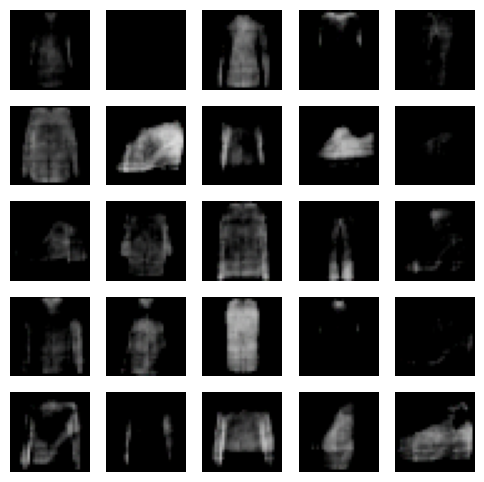

Images from Conv VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 288.20image/s]


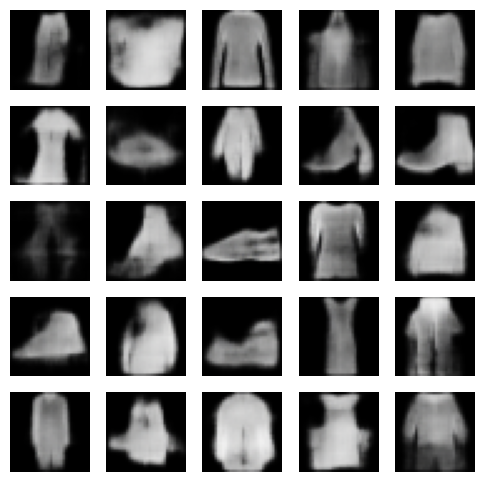

In [147]:
# Generate images
print('Images from FC VAE')
generate_images(fcvae, 'fcvae', num_images=25, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, 'cvae', num_images=25, latent_dim=128)

#### Image Interpolation

- **Function**: Interpolates between two images by encoding them into latent space, linearly blending their latent codes, and decoding the result.
- **Steps**:
  1. The images are encoded to latent representations.
  2. Latent codes are linearly interpolated over a specified number of steps.
  3. The interpolated latent codes are decoded back to images.
  4. The generated images are clamped to the [0, 1] range.
  
- **Visualization**: Displays the interpolated images in a horizontal grid.

In [148]:
# Function to interpolate between two images
def interpolate_images(model, model_name, image1, image2, device, num_steps=10):
    model.eval()
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        if model_name == 'fcvae':
            image1 = image1.view(-1, 3*32*32)
            image2 = image2.view(-1, 3*32*32)
        mu1, logvar1 = model.encode(image1.unsqueeze(0))
        mu2, logvar2 = model.encode(image2.unsqueeze(0))
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z1 + (1 - alpha) * z2
            reconstructed_image = model.decode(interpolated_z).cpu()
            interpolated_images.append(reconstructed_image)
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [151]:
def visualize_interpolation(model, model_name, dataset, num_steps=10):
    image1, _ = dataset[0]
    image2, _ = dataset[1]
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axs[i].imshow(interpolated_images[i].view(3, 32, 32).numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Interpolating between two images from the dataset for Conv VAE


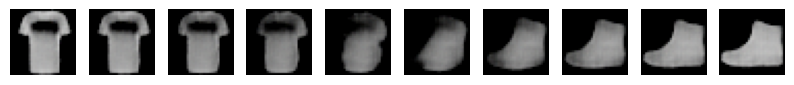

Interpolating between two images from the dataset for FC VAE


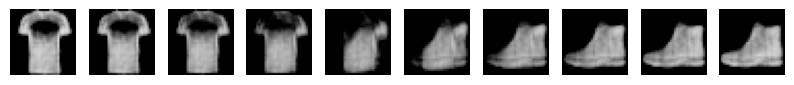

In [153]:
# Interpolate between two images from the dataset for Conv VAE
print('Interpolating between two images from the dataset for Conv VAE')
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=10)

# Interpolate between two images from the dataset for FC VAE
print('Interpolating between two images from the dataset for FC VAE')
visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=10)